In [1]:
# Parts A and B

import random
import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import cPickle
import math
import os

from collections import Counter
from pyspark.sql import SparkSession
from nltk.corpus import stopwords as Stopwords

from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, SparseVector

############################################################

def wordCountFlatMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    
    word_list = [(word, 1) for word in text if word not in GLOBAL_STOPWORDS_SET]
    return word_list

def wordCountReduce(x, y): # to be called with reduceByKey
    return x + y

def textParserMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    row_vector_dict = {}
    for word in text:
        if word in GLOBAL_VOCAB_TO_ID_DICT:
            word_id = GLOBAL_VOCAB_TO_ID_DICT[word]
            if word_id not in row_vector_dict:
                row_vector_dict[word_id] = 0
            row_vector_dict[word_id] += 1
            
    return SparseVector(len(GLOBAL_VOCAB_TO_ID_DICT), row_vector_dict)

def textParserWithIDMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    row_vector_dict = {}
    for word in text:
        if word in GLOBAL_VOCAB_TO_ID_DICT:
            word_id = GLOBAL_VOCAB_TO_ID_DICT[word]
            if word_id not in row_vector_dict:
                row_vector_dict[word_id] = 0
            row_vector_dict[word_id] += 1
            
    return (float(row[0]), SparseVector(len(GLOBAL_VOCAB_TO_ID_DICT), row_vector_dict))


############################################################

# Setup

NUM_PARTITIONS = 28 * 100
WORDCOUNT_CUTOFF = 25

NUM_BASELINE_TOPICS = 30

GLOBAL_STOPWORDS_SET = set(Stopwords.words('english'))
GLOBAL_VOCAB_TO_ID_DICT = {}
GLOBAL_ID_TO_VOCAB_DICT = {}

RAW_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsRaw.csv'
MERGED_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .config("spark.driver.maxResultSize", "32g")\
    .config("spark.executor.memory", "2g")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.csv(MERGED_DATAPATH).repartition(NUM_PARTITIONS)


# Part A
word_count_list = df.rdd.flatMap(wordCountFlatMap).reduceByKey(wordCountReduce).collect()
word_id = 0
for word, count in word_count_list:
    if count > WORDCOUNT_CUTOFF:
        GLOBAL_VOCAB_TO_ID_DICT[word] = word_id
        GLOBAL_ID_TO_VOCAB_DICT[word_id] = word
        word_id += 1

print "Constructed global vocabulary of length " + str(len(GLOBAL_VOCAB_TO_ID_DICT))

# Part B
print "Entering Part B"
# df = spark.read.csv(MERGED_DATAPATH).repartition(NUM_PARTITIONS)

train_rdd, test_rdd = df.rdd.randomSplit([9, 1])
lda = LDA(k=30, maxIter=100, optimizer="online")
lda_path = "my_lda_model_k_30"
lda_model = None

schema = ["id", "features"]
corpus_rdd = train_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
corpus_df = spark.createDataFrame(corpus_rdd, schema)

vectorized_test_rdd = test_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS/10)
test_df = spark.createDataFrame(vectorized_test_rdd, schema)

print "Training new model..."
lda_model = lda.fit(corpus_df)
print "Trained model"

print "Displaying topic summaries: "
terms_per_topic = 10
topics = lda_model.describeTopics(maxTermsPerTopic=terms_per_topic)
for topic in topics.collect():
    print "---------------------------------------"
    print topic[0]
    for word_id in topic[1]:
        print "\t" + str(GLOBAL_ID_TO_VOCAB_DICT[word_id])
    print "---------------------------------------"

print "Examining most probable topics for documents: "

reconstruction_list = []

sample_raw_rdd, _ = test_rdd.randomSplit([1,999])
sample_corpus_rdd = sample_raw_rdd.map(textParserWithIDMap)


# sample_rdd, _ = test_df.rdd.randomSplit([1,999])
sample_df = spark.createDataFrame(sample_corpus_rdd, schema)
transformed_df = lda_model.transform(sample_df)

transformed_data = transformed_df.rdd.collect()
print "Most probable topics: "
for row in transformed_data:
    doc_id = float(row[0])
    reconstruction_list.append(doc_id)
    topic_dist = sorted(enumerate(row[2].toArray()), reverse=True, key=lambda x: float(x[1]))
    
    print "------ For Doc. " + str(doc_id) + " ------"
    for i in range(5):
        print "\t Topic " + str(topic_dist[i][0]) + ": \t" + str(topic_dist[i][1])
                
print "\nDisplaying original documents: "
og_docs = sample_raw_rdd.collect()
for row in og_docs:
    print "\n" + str(row[0]) + ":\n" + str(row[1])

print "Stopping"
spark.stop()


Spark Session web UI: http://10.50.221.200:4040
Constructed global vocabulary of length 10883
Entering Part B
Training new model...
Trained model
Displaying topic summaries: 
---------------------------------------
0
	variable
	variables
	model
	data
	regression
	would
	one
	x
	use
	using
---------------------------------------
---------------------------------------
1
	volume
	circular
	brain
	angle
	iq
	orientation
	angles
	wind
	circle
	fallacy
---------------------------------------
---------------------------------------
2
	mediation
	path
	race
	kendall
	food
	tau
	self
	indirect
	paths
	mediator
---------------------------------------
---------------------------------------
3
	correlation
	time
	series
	stationary
	variables
	process
	data
	two
	coefficient
	trend
---------------------------------------
---------------------------------------
4
	sampling
	mcmc
	histogram
	posterior
	bin
	monte
	carlo
	density
	chain
	bins
---------------------------------------
-----------------

In [ ]:
# Comments:
# Part A:\
# To contruct our vocabulary, we removed non-alphabetic characters from our data, lower-cased it, and split it
# into words. We then calculated word counts, exclusing words with appeared in the NLTK stopwords package,
# and removed words which appeared less than 25 times. This process netted us a vocabulary of size 10833.
# Generally, we utilized standard cleaning procedures learned from previous assignments, with the exception of
# stripping numeric characters, which appear frequently in these documents and are not particualarly informative.
# We decided not to strip 1 character words such as "x", "y", and "r", as these words can actually be informative
# of things like axes and programming.

# Part B:
# Topic 0: data modeling
# Topic 1: general intelligence and social behaviour
# Topic 3: correlation/data trends
# Topic 4: sampling and Monte carlo modeling
# Topic 5: R programming and modeling
# Topic 6: Schooling
# Topic 7: Linear regression
# Topic 9: Scientific medical studies
# Topic 12: Distributions
# Topic 13: Estimation
# Topic 16: Hypothesis testing
# Topic 17: Clustering
# Topic 18: Time series
# Topic 20: Experiment design
# Topic 22: Fixed effects / panel based data
# Topic 24: SGD
# Topic 27: Classification
# Qualitatively examing the documents, we find that the document classifications make a good amount of sense
# For example, Document 188340 clearly deals with time series / modeling, as predicted. 
# Doc. 224695 deals with NN classification, as predicted.
# The greater the concentration of "keywords", however, increasing the number of significantly probable topics, as evidenced
# by documents such as 60648 and 4053. As a whole, the topic assignments generally make sense, and at worst are not
# completely nonsensical

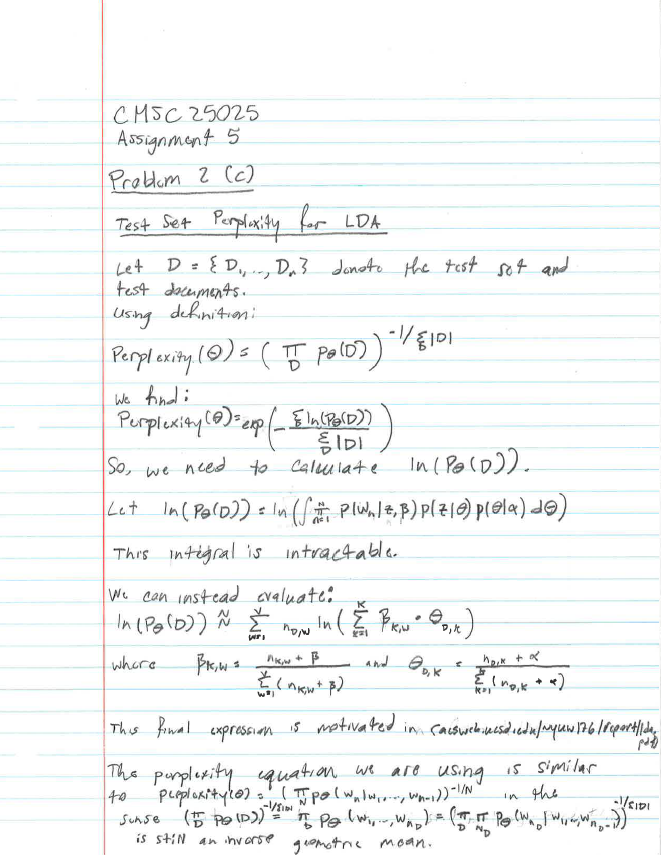

In [1]:
# Part C:

from IPython.display import Image
from IPython.display import display as Display

img_path = "assn5_p2c.png"

Display(Image(filename=img_path))

In [1]:
# Part D - P1

import random
import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import cPickle
import math
import os

from collections import Counter
from pyspark.sql import SparkSession
from nltk.corpus import stopwords as Stopwords

from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, SparseVector

############################################################

def wordCountFlatMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    
    word_list = [(word, 1) for word in text if word not in GLOBAL_STOPWORDS_SET]
    return word_list

def wordCountReduce(x, y): # to be called with reduceByKey
    return x + y

def textParserMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    row_vector_dict = {}
    for word in text:
        if word in GLOBAL_VOCAB_TO_ID_DICT:
            word_id = GLOBAL_VOCAB_TO_ID_DICT[word]
            if word_id not in row_vector_dict:
                row_vector_dict[word_id] = 0
            row_vector_dict[word_id] += 1
            
    return SparseVector(len(GLOBAL_VOCAB_TO_ID_DICT), row_vector_dict)

############################################################

# Setup

NUM_PARTITIONS = 28 * 100
WORDCOUNT_CUTOFF = 25

NUM_BASELINE_TOPICS = 30

GLOBAL_STOPWORDS_SET = set(Stopwords.words('english'))
GLOBAL_VOCAB_TO_ID_DICT = {}
GLOBAL_ID_TO_VOCAB_DICT = {}

RAW_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsRaw.csv'
MERGED_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .config("spark.driver.maxResultSize", "32g")\
    .config("spark.executor.memory", "3g")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.csv(MERGED_DATAPATH).repartition(NUM_PARTITIONS)

# Setup Vocab
word_count_list = df.rdd.flatMap(wordCountFlatMap).reduceByKey(wordCountReduce).collect()
word_id = 0
for word, count in word_count_list:
    if count > WORDCOUNT_CUTOFF:
        GLOBAL_VOCAB_TO_ID_DICT[word] = word_id
        GLOBAL_ID_TO_VOCAB_DICT[word_id] = word
        word_id += 1

print "Constructed global vocabulary of length " + str(len(GLOBAL_VOCAB_TO_ID_DICT))

schema = ["id", "features"]
vectorized_rdd = df.rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
vectorized_df = spark.createDataFrame(vectorized_rdd, schema)

train_rdd, test_rdd = vectorized_df.rdd.randomSplit([9, 1], seed=1)


# corpus_rdd = train_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
corpus_df = spark.createDataFrame(train_rdd, schema)

# test_rdd = test_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
test_df = spark.createDataFrame(test_rdd, schema)


# Part D
x_vals = []
y_vals = []
k_range = range(10, 50 + 1, 10)
terms_per_topic = 10
num_topics_to_display = 10
for k_val in k_range:
    print "\n ------------ Training model for k = " + str(k_val) + " ------------"
    lda = LDA(k=k_val, maxIter=33, optimizer="online")
    lda_model = lda.fit(corpus_df)
    
    perplexity = lda_model.logPerplexity(test_df)
    print "\tObtained perplexity of: " + str(perplexity)
    
    x_vals.append(k_val)
    y_vals.append(perplexity)
    
    topics = lda_model.describeTopics(maxTermsPerTopic=terms_per_topic)
    
    topic_count = num_topics_to_display
    for topic in topics.rdd.collect():
        if topic_count <= 0:
            break
        topic_count -= 1
        
        print "\t---------------------------------------"
        print "\t" + str(topic[0])
        for word_id in topic[1]:
            print "\t\t" + str(GLOBAL_ID_TO_VOCAB_DICT[word_id])
        print "\t---------------------------------------"

plt.clf()
plt.title("Num. topics v Perplexity")
plt.plot(x_vals, y_vals)

spark.stop()


Spark Session web UI: http://10.50.221.199:4040
Constructed global vocabulary of length 10883

 ------------ Training model for k = 10 ------------
	Obtained perplexity of: 7.59137958121
	---------------------------------------
	0
		data
		test
		variables
		would
		variable
		one
		two
		model
		use
		different
	---------------------------------------
	---------------------------------------
	1
		l
		mediation
		na
		reliability
		rater
		raters
		model
		x
		mean
		penalty
	---------------------------------------
	---------------------------------------
	2
		male
		patients
		female
		patient
		women
		people
		hospital
		males
		men
		females
	---------------------------------------
	---------------------------------------
	3
		time
		series
		data
		test
		correlation
		would
		group
		two
		treatment
		variables
	---------------------------------------
	---------------------------------------
	4
		distribution
		sample
		probability
		mean
		normal
		random
		value
		test
		one
		

In [ ]:
# Comments:
# Here, we have broken out the models with K = 10, 20,..., 50. We notice that the model with the fewest amount of topics
# (K = 10), has the lowest perplexity. This is, in hindsight, not particularly suprising, as we do not impose a limit on topic
# size, so a model with K = 1 will simply contain one topic that all documents will be classified into, making prediction
# irrelevant
# Qualitatively, we do not notice any significant difference in topic quality among K=10 - 50. However, we note that we are only
# displaying the top 10 words from each topic, and as such, it is likely the topics for K=10 make less sense than the ones
# for K=50 as you go down further down each topic's words. We did seem to notice that the topics become a little more
# specific as K increases. For example, topic 7 in K = 10 vs. K = 50 features more specific regression terms such as 
# "lasso" when K = 50
# These first parts are carved out because, when training on 90% of documents, the LDA library crashes deterministically on
# K = 70. Evidence below

In [1]:
# Part D - P2

import random
import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import cPickle
import math
import os

from collections import Counter
from pyspark.sql import SparkSession
from nltk.corpus import stopwords as Stopwords

from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, SparseVector

############################################################

def wordCountFlatMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    
    word_list = [(word, 1) for word in text if word not in GLOBAL_STOPWORDS_SET]
    return word_list

def wordCountReduce(x, y): # to be called with reduceByKey
    return x + y

def textParserMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    row_vector_dict = {}
    for word in text:
        if word in GLOBAL_VOCAB_TO_ID_DICT:
            word_id = GLOBAL_VOCAB_TO_ID_DICT[word]
            if word_id not in row_vector_dict:
                row_vector_dict[word_id] = 0
            row_vector_dict[word_id] += 1
            
    return SparseVector(len(GLOBAL_VOCAB_TO_ID_DICT), row_vector_dict)

############################################################

# Setup

NUM_PARTITIONS = 28 * 100
WORDCOUNT_CUTOFF = 25

NUM_BASELINE_TOPICS = 30

GLOBAL_STOPWORDS_SET = set(Stopwords.words('english'))
GLOBAL_VOCAB_TO_ID_DICT = {}
GLOBAL_ID_TO_VOCAB_DICT = {}

RAW_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsRaw.csv'
MERGED_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .config("spark.driver.maxResultSize", "32g")\
    .config("spark.executor.memory", "2g")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.csv(MERGED_DATAPATH).repartition(NUM_PARTITIONS)

# Setup Vocab
word_count_list = df.rdd.flatMap(wordCountFlatMap).reduceByKey(wordCountReduce).collect()
word_id = 0
for word, count in word_count_list:
    if count > WORDCOUNT_CUTOFF:
        GLOBAL_VOCAB_TO_ID_DICT[word] = word_id
        GLOBAL_ID_TO_VOCAB_DICT[word_id] = word
        word_id += 1

print "Constructed global vocabulary of length " + str(len(GLOBAL_VOCAB_TO_ID_DICT))

schema = ["id", "features"]
vectorized_rdd = df.rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
vectorized_df = spark.createDataFrame(vectorized_rdd, schema)

train_rdd, test_rdd = vectorized_df.rdd.randomSplit([9, 1],seed=1)


# corpus_rdd = train_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
corpus_df = spark.createDataFrame(train_rdd, schema)

# test_rdd = test_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
test_df = spark.createDataFrame(test_rdd, schema)


# Part D
x_vals = []
y_vals = []
k_range = range(60, 100 + 1, 10)
terms_per_topic = 10
num_topics_to_display = 10
for k_val in k_range:
    print "\n ------------ Training model for k = " + str(k_val) + " ------------"
    lda = LDA(k=k_val, maxIter=50, optimizer="online")
    lda_model = lda.fit(corpus_df)
    
    perplexity = lda_model.logPerplexity(test_df)
    print "\tObtained perplexity of: " + str(perplexity)
    
    x_vals.append(k_val)
    y_vals.append(perplexity)
    
    topics = lda_model.describeTopics(maxTermsPerTopic=terms_per_topic)
    
    topic_count = num_topics_to_display
    for topic in topics.rdd.collect():
        if topic_count <= 0:
            break
        topic_count -= 1
        
        print "\t---------------------------------------"
        print "\t" + str(topic[0])
        for word_id in topic[1]:
            print "\t\t" + str(GLOBAL_ID_TO_VOCAB_DICT[word_id])
        print "\t---------------------------------------"

plt.clf()
plt.title("Num. topics v Perplexity")
plt.plot(x_vals, y_vals)

spark.stop()


Spark Session web UI: http://10.50.221.201:4040
Constructed global vocabulary of length 10883

 ------------ Training model for k = 60 ------------
	Obtained perplexity of: 8.7943902034
	---------------------------------------
	0
		variables
		variable
		regression
		one
		model
		would
		two
		random
		distribution
		data
	---------------------------------------
	---------------------------------------
	1
		lr
		symptoms
		symptom
		heart
		flu
		plate
		cond
		virus
		failure
		antibody
	---------------------------------------
	---------------------------------------
	2
		two
		groups
		however
		level
		anova
		test
		decomposition
		use
		means
		different
	---------------------------------------
	---------------------------------------
	3
		path
		paths
		causation
		rand
		cold
		strike
		beer
		engine
		vitamin
		data
	---------------------------------------
	---------------------------------------
	4
		prior
		bayesian
		posterior
		sampling
		likelihood
		distribution
		probab

Py4JJavaError: An error occurred while calling o190.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 12 in stage 670.0 failed 4 times, most recent failure: Lost task 12.3 in stage 670.0 (TID 364576, 10.50.221.201, executor 0): java.io.FileNotFoundException: /tmp/spark-ac13482c-71f8-444d-8d9d-1fa102d4361d/executor-bd594455-0c9b-477f-858b-94edcb7a65f4/blockmgr-c51997fa-4f11-45a4-b542-7e8f8bc92ce5/19/temp_shuffle_d609c713-9165-4b22-a5ac-cdaee083338c (No such file or directory)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:102)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:115)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:241)
	at org.apache.spark.shuffle.sort.ShuffleExternalSorter.writeSortedFile(ShuffleExternalSorter.java:201)
	at org.apache.spark.shuffle.sort.ShuffleExternalSorter.closeAndGetSpills(ShuffleExternalSorter.java:405)
	at org.apache.spark.shuffle.sort.UnsafeShuffleWriter.closeAndWriteOutput(UnsafeShuffleWriter.java:209)
	at org.apache.spark.shuffle.sort.UnsafeShuffleWriter.write(UnsafeShuffleWriter.java:169)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1981)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1025)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1007)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1127)
	at org.apache.spark.mllib.clustering.OnlineLDAOptimizer.submitMiniBatch(LDAOptimizer.scala:479)
	at org.apache.spark.mllib.clustering.OnlineLDAOptimizer.next(LDAOptimizer.scala:449)
	at org.apache.spark.mllib.clustering.OnlineLDAOptimizer.next(LDAOptimizer.scala:262)
	at org.apache.spark.mllib.clustering.LDA.run(LDA.scala:334)
	at org.apache.spark.ml.clustering.LDA.fit(LDA.scala:901)
	at org.apache.spark.ml.clustering.LDA.fit(LDA.scala:809)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: /tmp/spark-ac13482c-71f8-444d-8d9d-1fa102d4361d/executor-bd594455-0c9b-477f-858b-94edcb7a65f4/blockmgr-c51997fa-4f11-45a4-b542-7e8f8bc92ce5/19/temp_shuffle_d609c713-9165-4b22-a5ac-cdaee083338c (No such file or directory)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:102)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:115)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:241)
	at org.apache.spark.shuffle.sort.ShuffleExternalSorter.writeSortedFile(ShuffleExternalSorter.java:201)
	at org.apache.spark.shuffle.sort.ShuffleExternalSorter.closeAndGetSpills(ShuffleExternalSorter.java:405)
	at org.apache.spark.shuffle.sort.UnsafeShuffleWriter.closeAndWriteOutput(UnsafeShuffleWriter.java:209)
	at org.apache.spark.shuffle.sort.UnsafeShuffleWriter.write(UnsafeShuffleWriter.java:169)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
# Comments:
# When training on 90% of documents, the LDA library crashes deterministically on
# K = 70. Evidence below.
# As a result, for k = 70 to 100, we reduce the training set size to 1% of original, which allows it to run
# We tried reducing to 10% first, but this still caused crashes

In [1]:
# Part D - P3

import random
import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import cPickle
import math
import os

from collections import Counter
from pyspark.sql import SparkSession
from nltk.corpus import stopwords as Stopwords

from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, SparseVector

############################################################

def wordCountFlatMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    
    word_list = [(word, 1) for word in text if word not in GLOBAL_STOPWORDS_SET]
    return word_list

def wordCountReduce(x, y): # to be called with reduceByKey
    return x + y

def textParserMap(row):
    text = re.sub("[^a-zA-Z ]+", ' ', row[1]).lower().split()
    row_vector_dict = {}
    for word in text:
        if word in GLOBAL_VOCAB_TO_ID_DICT:
            word_id = GLOBAL_VOCAB_TO_ID_DICT[word]
            if word_id not in row_vector_dict:
                row_vector_dict[word_id] = 0
            row_vector_dict[word_id] += 1
            
    return SparseVector(len(GLOBAL_VOCAB_TO_ID_DICT), row_vector_dict)

############################################################

# Setup

NUM_PARTITIONS = 28 * 100
WORDCOUNT_CUTOFF = 25

NUM_BASELINE_TOPICS = 30

GLOBAL_STOPWORDS_SET = set(Stopwords.words('english'))
GLOBAL_VOCAB_TO_ID_DICT = {}
GLOBAL_ID_TO_VOCAB_DICT = {}

RAW_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsRaw.csv'
MERGED_DATAPATH = '/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .config("spark.driver.maxResultSize", "32g")\
    .config("spark.executor.memory", "3g")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.csv(MERGED_DATAPATH).repartition(NUM_PARTITIONS)

# Setup Vocab
word_count_list = df.rdd.flatMap(wordCountFlatMap).reduceByKey(wordCountReduce).collect()
word_id = 0
for word, count in word_count_list:
    if count > WORDCOUNT_CUTOFF:
        GLOBAL_VOCAB_TO_ID_DICT[word] = word_id
        GLOBAL_ID_TO_VOCAB_DICT[word_id] = word
        word_id += 1

print "Constructed global vocabulary of length " + str(len(GLOBAL_VOCAB_TO_ID_DICT))

schema = ["id", "features"]
vectorized_rdd = df.rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
vectorized_df = spark.createDataFrame(vectorized_rdd, schema)

train_rdd, test_rdd, _ = vectorized_df.rdd.randomSplit([1, 1, 90],seed=1) # Switching because using 90% causes an error


# corpus_rdd = train_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
corpus_df = spark.createDataFrame(train_rdd, schema)

# test_rdd = test_rdd.map(textParserMap).zipWithIndex().map(lambda x: [x[1], x[0]]).repartition(NUM_PARTITIONS)
test_df = spark.createDataFrame(test_rdd, schema)


# Part D
x_vals = []
y_vals = []
k_range = range(70, 100 + 1, 10)
terms_per_topic = 10
num_topics_to_display = 10
for k_val in k_range:
    print "\n ------------ Training model for k = " + str(k_val) + " ------------"
    lda = LDA(k=k_val, maxIter=50, optimizer="online")
    lda_model = lda.fit(corpus_df)
    
    perplexity = lda_model.logPerplexity(test_df)
    print "\tObtained perplexity of: " + str(perplexity)
    
    x_vals.append(k_val)
    y_vals.append(perplexity)
    
    topics = lda_model.describeTopics(maxTermsPerTopic=terms_per_topic)
    
    topic_count = num_topics_to_display
    for topic in topics.rdd.collect():
        if topic_count <= 0:
            break
        topic_count -= 1
        
        print "\t---------------------------------------"
        print "\t" + str(topic[0])
        for word_id in topic[1]:
            print "\t\t" + str(GLOBAL_ID_TO_VOCAB_DICT[word_id])
        print "\t---------------------------------------"

plt.clf()
plt.title("Num. topics v Perplexity")
plt.plot(x_vals, y_vals)

spark.stop()


Spark Session web UI: http://10.50.221.201:4040
Constructed global vocabulary of length 10883

 ------------ Training model for k = 70 ------------
	Obtained perplexity of: 21.1600073104
	---------------------------------------
	0
		data
		model
		one
		test
		use
		would
		two
		using
		variables
		variable
	---------------------------------------
	---------------------------------------
	1
		speeds
		since
		framework
		disagrees
		principles
		western
		tufte
		seedlings
		particular
		marketing
	---------------------------------------
	---------------------------------------
	2
		enrollment
		tseries
		dof
		colours
		agglomerative
		materials
		opposite
		measurment
		communities
		resulting
	---------------------------------------
	---------------------------------------
	3
		test
		set
		data
		mean
		value
		regression
		training
		linear
		computing
		used
	---------------------------------------
	---------------------------------------
	4
		trickier
		dsaxton
		martingale
		l

In [ ]:
# Comments:
# As mentioned above, we reduce the training set size to 1% of original, which allows it to run
# As expected, we notice that topic quality decreases significantly when withholding a lot of documents,
# as LDA is fairly data-hungry. Further, perplexity singificantly increases, which again is unsurpising, as
# the predictive power of this model should decrease with topic quality. As such, it is difficult to decide
# which model is "best", as lower perplexity does not nessecarily imply a "better" model. It is ultimately
# up to the reader to examine the topics and decide which model they prefer, but we believe that K=50 or K=60
# would be good choices for this model. We are unable to make determination for K > 60, given our
# computing restraints

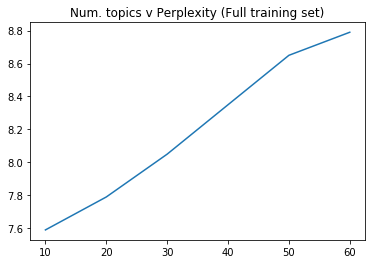

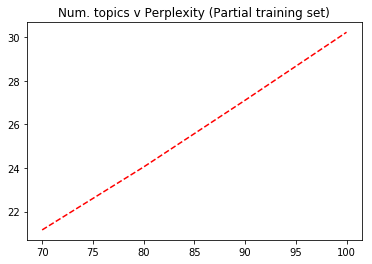

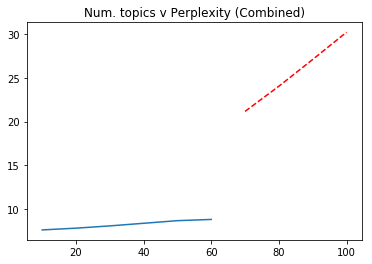

In [2]:
# Part D - plot

import numpy as np
import matplotlib.pyplot as plt

x_vector_full = range(10, 60 + 1, 10)
y_vector_full = [7.59, 7.79, 8.05, 8.35, 8.65, 8.79]

x_vector_partial = range(70, 100 + 1, 10)
y_vector_partial = [21.16, 24.044, 27.103, 30.22]

plt.clf()
plt.title("Num. topics v Perplexity (Full training set)")
plt.plot(x_vector_full, y_vector_full)
plt.show()

plt.clf()
plt.title("Num. topics v Perplexity (Partial training set)")
plt.plot(x_vector_partial, y_vector_partial, 'r--')
plt.show()

plt.clf()
plt.title("Num. topics v Perplexity (Combined)")
plt.plot(x_vector_full, y_vector_full)
plt.plot(x_vector_partial, y_vector_partial, 'r--')
plt.show()



In [ ]:
# Comments:
# We notice that validation perplexity on both models (full training set/partial training set) is monotonically increasing.
# This is perhaps suprising, but given the definition of perplexity, makes sense as we do not impose a limit on topic
# size, so a model with K = 1 will simply contain one topic that all documents will be classified into, making prediction
# easy. As K increases, intuitively, the task of prediction becomes harder as there are simply more options to choose from, and
# and henceforth more options to choose incorrectly